# EFC 3 - Redes Neurais - IA048

## Aluno: Jitesh Ashok Manilal Vassaram, RA:175867

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
data = np.load('../EFC3/bloodmnist.npz')

In [3]:
TrainX = data["train_images"]
TrainY = data["train_labels"]
ValX = data["val_images"]
ValY = data["val_labels"]
TestX = data["test_images"]
TestY = data["test_labels"]

In [4]:
print(f'dados de treinamento: \n {len(TrainX[0])}')

print('--'*20)
print(f'\n {TrainX/255}')

dados de treinamento: 
 28
----------------------------------------

 [[[[0.98039216 0.8745098  0.80784314]
   [1.         0.89803922 0.83137255]
   [0.98431373 0.87058824 0.80784314]
   ...
   [1.         0.93333333 0.76470588]
   [0.98431373 0.90196078 0.7254902 ]
   [1.         0.91764706 0.74901961]]

  [[1.         0.89803922 0.82352941]
   [1.         0.89803922 0.82352941]
   [0.95686275 0.84313725 0.78039216]
   ...
   [0.99607843 0.90980392 0.75686275]
   [0.99607843 0.91372549 0.74509804]
   [1.         0.94901961 0.78823529]]

  [[1.         0.90588235 0.81568627]
   [1.         0.89019608 0.80392157]
   [0.93333333 0.82352941 0.74117647]
   ...
   [1.         0.91372549 0.79215686]
   [0.98431373 0.89803922 0.75294118]
   [1.         0.94901961 0.79607843]]

  ...

  [[0.91372549 0.8        0.6745098 ]
   [0.9372549  0.82352941 0.70588235]
   [0.96078431 0.85490196 0.7372549 ]
   ...
   [1.         0.88235294 0.78039216]
   [1.         0.88627451 0.78431373]
   [1.         

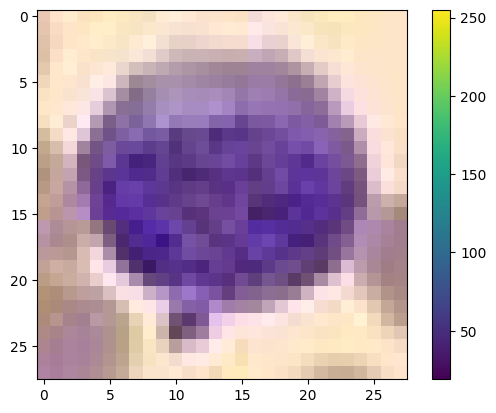

In [5]:
plt.imshow(TestX[0])
plt.colorbar()
plt.show()

In [6]:
TrainX_n = TrainX/255
TestX_n = TestX/255
ValX_n = ValX/255

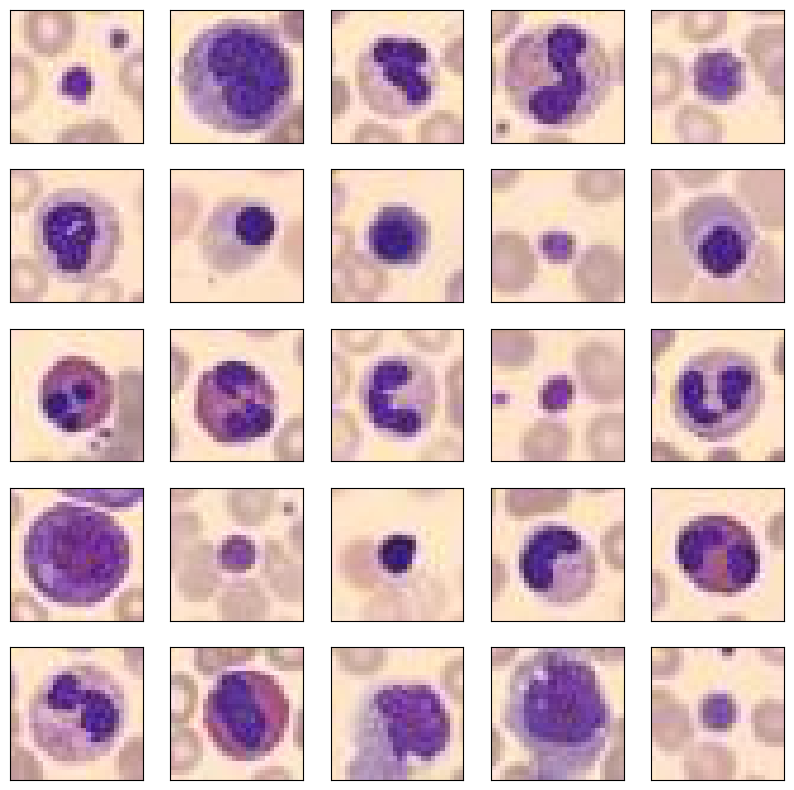

In [7]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(TrainX_n[i], cmap=plt.cm.binary)
    # plt.xlabel(class_names[TrainY[i]])
plt.show()

# Criação do modelo CNN profunda

Será implementado uma CNN profunda. Será tomada como base a DenseNet para a construção da CNN.

Para a construção, utilizou-se o seguinte exemplo que aplica uma DenseNet:
[Classificação_KERAS_DenseNet](https://towardsdatascience.com/exploring-densenets-from-paper-to-keras-dcc01725488b)

In [42]:
def H(input, num_filters, dropout_rate):
    
    x = tf.keras.layers.BatchNormalization()(input)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.Conv2D(num_filters,kernel_size=(1,1),use_bias=False)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.ZeroPadding2D((1,1))(x)
    x = tf.keras.layers.Conv2D(num_filters, kernel_size=(3,3),use_bias=False)(x)
    x = tf.keras.layers.Dropout(rate=dropout_rate)(x)

    return x

In [43]:
def transition(inputs, num_filters, compression_factor, dropout_rate,eps):
    
    x = tf.keras.layers.BatchNormalization()(inputs)
    x = tf.keras.layers.Activation('relu')(x)
    num_feature_maps = inputs.shape[1]

    x = tf.keras.layers.Conv2D(np.floor(compression_factor * num_feature_maps).astype(np.int64), kernel_size=(1,1), use_bias=False, padding='same', kernel_regularizer=tf.keras.regularizers.l2( eps ) )(x)
    x = tf.keras.layers.Dropout(rate=dropout_rate)(x)
    x = tf.keras.layers.AveragePooling2D(pool_size=(2,2))(x)
    return x

In [44]:
def dense_blk(inputs, num_layers, num_filters, growth_rate, dropout_rate,eps):
    
    for i in range(num_layers):
        conv_out = H(inputs, num_filters, dropout_rate)
        inputs = tf.keras.layers.Concatenate()([conv_out,inputs])
        num_filters += growth_rate


    return inputs, num_filters

In [45]:
# Programa Final para construir o modelo.

input_shape = (28,28,3)
eps = 1.1e-4
num_block = 2
num_layer_pblock = 2
growth_rate = 8
dropout_rate = 0.4
compression_factor = 0.5

num_filters = 8

inputs = tf.keras.layers.Input(shape=input_shape)
x = tf.keras.layers.Conv2D(num_filters, kernel_size=(3,3), use_bias=False, kernel_regularizer=tf.keras.regularizers.l2(eps))(inputs)

for i in range(num_block):
    x,num_filters = dense_blk(x, num_layer_pblock, num_filters, growth_rate, dropout_rate,eps)
    x = transition(x, num_filters, compression_factor, dropout_rate,eps)

x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(8)(x)

output = tf.keras.layers.Activation('softmax')(x)


In [46]:
model = tf.keras.models.Model(inputs, output)

model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(), optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['acc'])
model.summary()

Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 28, 28, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_79 (Conv2D)  │ (None, 26, 26, 8) │        216 │ input_layer_5[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 26, 26, 8) │         32 │ conv2d_79[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_79       │ (None, 26, 26, 8) │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_80 (Conv2D)  │ (None, 26, 26, 8) │         64 │ activation_79[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 26, 26, 8) │         32 │ conv2d_80[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_80       │ (None, 26, 26, 8) │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_32   │ (None, 28, 28, 8) │          0 │ activation_80[0]… │
│ (ZeroPadding2D)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_81 (Conv2D)  │ (None, 26, 26, 8) │        576 │ zero_padding2d_3… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_42          │ (None, 26, 26, 8) │          0 │ conv2d_81[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_32      │ (None, 26, 26,    │          0 │ dropout_42[0][0], │
│ (Concatenate)       │ 16)               │            │ conv2d_79[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 26, 26,    │         64 │ concatenate_32[0… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_81       │ (None, 26, 26,    │          0 │ batch_normalizat… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_82 (Conv2D)  │ (None, 26, 26,    │        256 │ activation_81[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 26, 26,    │         64 │ conv2d_82[0][0]   │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_82       │ (None, 26, 26,    │          0 │ batch_normalizat… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_33   │ (None, 28, 28,    │          0 │ activation_82[0]… │
│ (ZeroPadding2D)     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_83 (Conv2D)  │ (None, 26, 26,    │      2,304 │ zero_padding2d_3

 Total params: 21,218 (82.88 KB)

 Trainable params: 20,708 (80.89 KB)

 Non-trainable params: 510 (1.99 KB)

In [47]:
batch_size = 64
epochs = 100

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
# hist = model.fit(datagen.flow(TrainX_n, TrainY, batch_size=batch_size, seed=seed),epochs=epochs, batch_size=batch_size, validation_data=(ValX_n,ValY))
hist = model.fit(TrainX_n,TrainY,epochs=epochs, batch_size=batch_size, validation_data=(ValX_n,ValY),callbacks=[early_stopping, reduce_lr])

Epoch 1/100
187/187 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - acc: 0.4158 - loss: 1.6227 - val_acc: 0.2185 - val_loss: 3.2882 - learning_rate: 0.0010
Epoch 2/100
187/187 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - acc: 0.7575 - loss: 0.7536 - val_acc: 0.2150 - val_loss: 3.8685 - learning_rate: 0.0010
Epoch 3/100
187/187 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - acc: 0.8119 - loss: 0.5654 - val_acc: 0.4959 - val_loss: 1.4920 - learning_rate: 0.0010
Epoch 4/100
187/187 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - acc: 0.8260 - loss: 0.5018 - val_acc: 0.8061 - val_loss: 0.5457 - learning_rate: 0.0010
Epoch 5/100
187/187 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - acc: 0.8473 - loss: 0.4513 - val_acc: 0.2424 - val_loss: 3.7051 - learning_rate: 0.0010
Epoch 6/100
187/187 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - acc: 0.8539 - loss: 0.4337 - val_acc: 0.8032 - val_loss: 0.5686 - learning_rate: 0.0010
Epoch 7/100
187/187 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - acc: 0.8613 - loss: 0.4033 - val_acc: 0.6098 - val_loss: 1.2610 - learning_rate

In [ ]:
del model

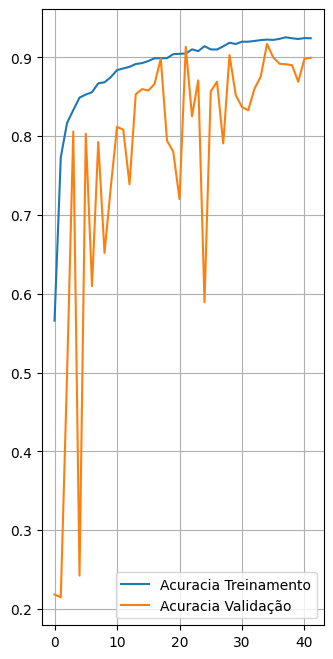

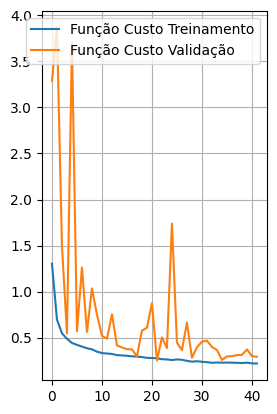

In [48]:
acc = hist.history['acc']
validation_acc = hist.history['val_acc']

loss = hist.history['loss']
val_loss = hist.history['val_loss']

range_epochs = np.arange(42)

plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range_epochs,acc, label='Acuracia Treinamento')
plt.plot(range_epochs,validation_acc, label='Acuracia Validação')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

plt.subplot(1,2,2)
plt.plot(range_epochs,loss, label='Função Custo Treinamento')
plt.plot(range_epochs,val_loss, label='Função Custo Validação')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

In [49]:
import itertools
#Plot the confusion matrix. Set Normalize = True/False
def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=2)
        cm[np.isnan(cm)] = 0.0
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - acc: 0.8895 - loss: 0.3108
Função-Custo: 0.28628772497177124
Acurácia: 0.90324467420578
----------------------------------------------------------------------------------------------------


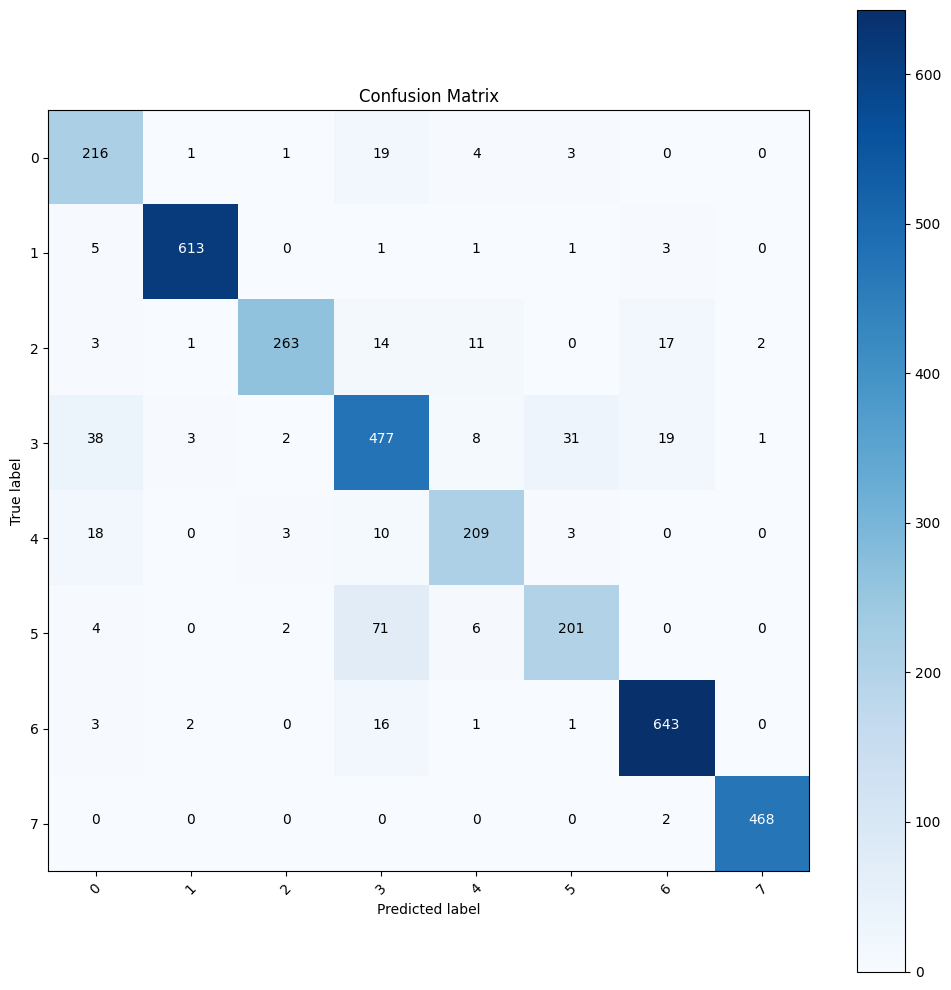

In [50]:
from sklearn.metrics import confusion_matrix
import pandas as pd

pred = model.predict(TestX_n,batch_size=batch_size)

y_pred = np.empty((len(pred),1),dtype=int)
for i in range(len(pred)):
    y_pred[i,0] = np.argmax(pred[i])

score = model.evaluate(TestX_n,TestY,batch_size=batch_size)

print(f'Função-Custo: {score[0]}')
print(f'Acurácia: {score[1]}')

print('--'*50)

cm = confusion_matrix(TestY,y_pred)
plot_confusion_matrix(cm, ['0', '1', '2', '3', '4', '5', '6', '7'], normalize=False, title='Confusion Matrix')

In [ ]:
def plot_image(i, predictions_array, true_label, img):
  true_label, img = true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(predicted_label,
                                100*np.max(predictions_array),
                                true_label),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  true_label = true_label[i]
  plt.grid(False)
  plt.xticks(range(8))
  plt.yticks([])
  thisplot = plt.bar(range(8), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label[0]].set_color('blue')



num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, pred[i], TestY, TestX)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, pred[i], TestY)
plt.tight_layout()
plt.show()



In [ ]:
i = 19
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, pred[i], TestY, TestX)
plt.subplot(1,2,2)
plot_value_array(i, pred[i],  TestY)
plt.show()

In [ ]:
plt.imshow(TestX[10])
plt.show()

In [ ]:
plt.imshow(TestX[33])
plt.show()